In [2]:
# To see variance of combustion properties between chamber, throat and exit. Not too much so I'll assume everything is chamber for now.
from rocketcea.cea_obj import CEA_Obj

ispObj = CEA_Obj( oxName='N2O', fuelName='Isopropanol')
s = ispObj.get_full_cea_output( Pc=20, # number or list of chamber pressures
                                MR=0.5,   # number or list of mixture ratios
                                # PcOvPe=5,# number or list of Pc/Pexit
                                eps=4,   # number or list of supersonic area ratios
                                # subar=5,     # number or list of subsonic area ratios
                                short_output=1,  # 0 or 1 to control output length
                                pc_units='bar', # pc_units = 'psia', 'bar', 'atm', 'mmh'
                                output='siunits',# output = 'calories' or 'siunits'
                                fac_CR=None)     # finite area combustor, contraction ratio
print( s )


 *******************************************************************************

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA, OCTOBER 18, 2002
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************



 reac
  fuel C3H8O-2propanol C 3 H 8 O 1    wt%=100.
  h,cal=-65133.     t(k)=298.15   rho=0.786
  oxid NitrousOxide  N 2.0 O 1.0  wt%=100.00
  h,cal= 19467.0 t(k)=298.15
  
 prob case=RocketCEA,
  rocket equilibrium   p,bar=20.000000,  supar=4.000000,
  o/f=0.500000,
  
  
 output siunits  short  transport
 end






              THEORETICAL ROCKET PERFORMANCE ASSUMING EQUILIBRIUM

           COMPOSITION DURING EXPANSION FROM INFINITE AREA COMBUSTOR

 Pinj =   290.1 PSIA
 CASE = RocketCEA,     

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)   

In [9]:

import cProfile

import numpy as np
from scipy.optimize import root_scalar
from rocketcea.cea_obj_w_units import CEA_Obj

from bearing import Bearing
from mechanicalseal import MechanicalSeal
import matplotlib.pyplot as plt

# from rocketcea.cea_obj import add_new_fuel
# from pyfluids import Fluid, FluidsList, Input
# import numpy as np

# class combustion_results:
#     def __init__(self, tc, cp):
#         self.tc = tc
#         self.cp = cp
    
#     def pretty_print(self):
#         print(f"Combustion Results:")
#         print(f"  {'Combustion Temperature (Tc)':<30} {self.tc:<10.4g} K")
#         print(f"  {'Combustion Heat Capacity (Cp)':<30} {self.cp:<10.4g} J/kg/K")

class GasGenerator:
    def __init__(self, ox: str, fuel: str):
        self.ox = ox
        self.fuel = fuel
        self.cea = CEA_Obj(
            oxName = self.ox,
            fuelName = self.fuel,
            isp_units='sec',
            cstar_units = 'm/s',
            pressure_units='Bar',
            temperature_units='K',
            sonic_velocity_units='m/s',
            enthalpy_units='J/kg',
            density_units='kg/m^3',
            specific_heat_units='J/kg-K',
            viscosity_units='centipoise', # stored value in pa-s
            thermal_cond_units='W/cm-degC', # stored value in W/m-K
            # fac_CR=self.cr,
            make_debug_prints=False)
    def combustion_sim(self, OF, pc):
        Tg_c = self.cea.get_Tcomb(Pc=pc, MR=OF)
        [mw_c, gam_c] = self.cea.get_Chamber_MolWt_gamma(Pc=pc, MR=OF, eps=40)
        R_c = 8314.5 / mw_c  # J/kg-K
        Cp_c = self.cea.get_Chamber_Cp(Pc=pc, MR=OF, eps=40)
        # print(f"mw={mw_c}, R={R_c}, gam={gam_c}, Cp={Cp_c}")
        return Tg_c, Cp_c, R_c, gam_c
    

class Engine:
    def __init__(self, ox: str, fuel: str):
        self.ox = ox
        self.fuel = fuel
        self.cea = CEA_Obj(
            oxName = self.ox,
            fuelName = self.fuel,
            isp_units='sec',
            cstar_units = 'm/s',
            pressure_units='Bar',
            temperature_units='K',
            sonic_velocity_units='m/s',
            enthalpy_units='J/g',
            density_units='kg/m^3',
            specific_heat_units='J/kg-K',
            viscosity_units='centipoise', # stored value in pa-s
            thermal_cond_units='W/cm-degC', # stored value in W/m-K
            # fac_CR=self.cr,
            make_debug_prints=False)
        
    def size(self, OF, pc, pe, thrust):
        eps = self.cea.get_eps_at_PcOvPe(Pc=pc, MR=OF, PcOvPe=pc/pe)
        _, cf, _ = self.cea.get_PambCf(Pamb=pe, Pc=pc, MR=OF, eps=eps)
        at = thrust / (cf * pc * 1e5)
        cstar = self.cea.get_Cstar(Pc=pc, MR=OF)
        mdot = pc * 1e5 * at / cstar
        isp_sea, _ = self.cea.estimate_Ambient_Isp(Pamb=pe, Pc=pc, MR=OF, eps=eps)
        return eps, cf, at, cstar, mdot, isp_sea
    
class Turbine:
    def __init__(self, 
                 P,       # W
                 RPM,     
                 d_mean_mm, # mm
                 mdot,     # kg/s
                 beta_deg,   # degrees
                 doa,       # degree of admission
                 p_e,  # exit pressure [Pa]
                 ):     
        
        # Store inputs
        self.P = P
        self.RPM = RPM
        self.d_mean_mm = d_mean_mm
        self.mdot = mdot
        self.beta = np.deg2rad(beta_deg)
        self.doa = doa
        self.p_e = p_e
        
        
        # Derived inputs
        self.d_mean = d_mean_mm / 1000

        # Angular velocity & blade speed
        self.w = self.RPM * 2 * np.pi / 60
        self.u = self.w * self.d_mean / 2
        
        # Useful enthalpy drop
        self.deltah_useful = self.P / self.mdot
        
        # Velocity triangles
        self.c3u = self.deltah_useful / (2 * self.u) + self.u
        self.c3 = self.c3u / np.cos(self.beta)
        self.c3m = self.c3 * np.sin(self.beta)

        # Swirl velocity at outlet
        self.c4u = self.u - (self.c3u - self.u)
        self.c4 = np.sqrt(self.c4u**2 + self.c3m**2)  
        
    def from_gasgen(self, cea: CEA_Obj, OF):
        self.cea = cea
        self.OF = OF
        # Find chamber pressure and expansion ratio        
        def expansion_func(eps, p01, c3):
            return c3 - self.cea.get_SonicVelocities(Pc=p01/1e5, MR=self.OF, eps=eps)[2] * self.cea.get_MachNumber(Pc=p01/1e5, MR=self.OF, eps=eps)

        rel_diff = 1
        self.p01 = self.p_e * 5  # Initial guess for total pressure at inlet
        iteration = 0
        if False:
            def test_expansion(eps, p01):
                return self.cea.get_SonicVelocities(Pc=p01/1e5, MR=self.OF, eps=eps)[2] * self.cea.get_MachNumber(Pc=p01/1e5, MR=self.OF, eps=eps)
            # Root scalar is failing, so plot expansion_func to find root visually
            import matplotlib.pyplot as plt
            eps_values = np.linspace(0, 50, 100)
            func_values = [expansion_func(eps, self.p01, self.c3) for eps in eps_values]
            func2_values = [test_expansion(eps, self.p01) for eps in eps_values]
            plt.plot(eps_values, func_values)
            plt.plot(eps_values, func2_values, label='test_expansion')
            plt.xlabel('Expansion Ratio (eps)')
            plt.ylabel('Expansion Function Value')
            plt.title('Expansion Function vs Expansion Ratio')
            plt.grid(True)
            plt.show()

            print(f"p01 guess: {self.p01/1e5:.2f} bar, c3: {self.c3:.2f} m/s")
            # Stop code here to inspect the plot
            return

        while rel_diff > 5e-4:
            self.eps = root_scalar(expansion_func, args=(self.p01, self.c3), bracket=[1, 50]).root
            self.p3 = self.p01 / self.cea.get_PcOvPe(Pc=self.p01/1e5, MR=self.OF, eps=self.eps)
            rel_diff = abs((self.p3 - self.p_e) / self.p_e)
            self.p01 *= self.p_e / self.p3
            iteration += 1
            if iteration > 10:
                return
        # print(f"Turbine sizing converged in {iteration} iterations.")

        # Outlet conditions
        self.T01, _, self.T3 = self.cea.get_Temperatures(Pc=self.p01/1e5, MR=self.OF, eps=self.eps)
        _ , self.a_throat, self.a3 = self.cea.get_SonicVelocities(Pc=self.p01/1e5, MR=self.OF, eps=self.eps)
        self.M3 = self.cea.get_MachNumber(Pc=self.p01/1e5, MR=self.OF, eps=self.eps)
        
        # Pressure & density at blade inlet
        # self.p3 = self.p01 / (1 + 0.5 * (self.gam - 1) * self.M3**2)**(self.gam/(self.gam-1))
        _, self.rho_throat, self.rho_3 = self.cea.get_Densities(Pc=self.p01/1e5, MR=self.OF, eps=self.eps)
        
        # Blade height
        self.Height = self.mdot / (self.doa * self.rho_3 * self.c3m * self.d_mean * np.pi)
        
        # Isentropic expansion to ambient
        # self.T_amb_is = self.T01 * (self.pamb/self.p01)**((self.gam - 1)/self.gam)
        # Isentropic expansion to static
        self.deltah_ambis = 0.5 * self.c3**2
        
        # Efficiency
        self.eff = self.deltah_useful / self.deltah_ambis
        # Huzel and huang efficiency

        # Blade-jet speed ratio
        self.blade_jet_speed_ratio = self.u / np.sqrt(2 * self.deltah_ambis)

        # Specific Speed
        self.q = self.mdot / (self.rho_3)
        self.specific_speed = self.RPM * np.sqrt(self.q) / (self.P**(3/4))

        # Total throat area
        self.A_throat = self.mdot / (self.rho_throat * self.a_throat)
        self.nozzles = 4
        self.nozzle_throat_length = self.A_throat / self.nozzles / self.Height
        self.nozzle_exit_length = self.eps * self.A_throat / self.nozzles / self.Height

        # Tg_c = self.cea.get_Tcomb(Pc=pc, MR=OF)
        mw3, self.gam3 = self.cea.get_exit_MolWt_gamma(Pc=self.p01/1e5, MR=self.OF, eps=self.eps)
        self.R_3 = 8314.5 / mw3  # J/kg-K
        # Cp_3 = self.cea.get_Chamber_Cp(Pc=pc, MR=OF, eps=40)

        # Throat to exit area ratio
        # gam = self.gam
        # self.eps = (( (gam + 1)/2 )**( - (gam + 1) / (2 * (gam - 1)) )) * ( 1 + 0.5 * (gam - 1) * self.M3**2 )**( (gam + 1) / (2 * (gam - 1)) ) * (1 / self.M3)

        # Nitrogen required calculations
        self.T01_n2 = 300  # K
        self.cp_n2 = 1040  # J/kg/K
        self.R_n2 = 296.8  # J/kg/K
        self.gam_n2 = 1.4

        rel_diff = 1
        p01_n2 = self.p01 * 5 # Initial guess
        iteration = 0


        def machfunc(mach, area_ratio, gam):
            if mach == 0:
                mach = 1e-7
            return area_ratio - ((1.0/mach) * ((1 + 0.5*(gam-1)*mach*mach) / ((gam + 1)/2))**((gam+1) / (2*(gam-1))))
        
        # self.M[i] = root_scalar(machfunc, args=(A, self.gamma[i]), bracket=[1, 5]).root
        
        while rel_diff > 5e-4:
            M3_n2 = root_scalar(machfunc, args=(self.eps, self.gam_n2), bracket=[1, 5]).root
            T3_n2 = self.T01_n2 / (1 + 0.5 * (self.gam_n2 - 1) * M3_n2**2)
            p3_n2 = p01_n2 / (1 + 0.5 * (self.gam_n2 - 1) * M3_n2**2)**(self.gam_n2/(self.gam_n2-1))
            rho3_n2 = p3_n2 / (self.R_n2 * T3_n2)
            
            c3_n2 = M3_n2 * np.sqrt(self.gam_n2 * self.R_n2 * T3_n2)

            c3u_n2 = c3_n2 * np.cos(self.beta)

            deltah_useful_n2 = 2 * self.u * (c3u_n2 - self.u)
            mdot_n2 = self.A_throat * p01_n2 / np.sqrt(self.T01_n2) * np.sqrt(self.gam_n2 / self.R_n2) * ((2 / (self.gam_n2 + 1))**((self.gam_n2 + 1) / (2 * (self.gam_n2 - 1)))) 
            P_n2 = mdot_n2 * deltah_useful_n2

            rel_diff = abs((P_n2 - self.P) / self.P)
            # print(f"Iteration {iteration}: p01_n2 = {p01_n2/1e5:.2f} bar, p3_n2 = {p3_n2/1e5:.2f} bar, P_n2 = {P_n2:.2f} W, rel_diff = {rel_diff:.6f}")
            # print(f"it={iteration}, p01={p01_n2/1e5:.2f} bar, p3={p3_n2/1e5:.2f} bar, c3={c3_n2:.2f} m/s, M3={M3_n2:.2f}, P_n2={P_n2:.2f} W, rel_diff={rel_diff:.2e}")
            # print(f"mdot={mdot_n2*1000:.2f} g/s, deltah_useful={deltah_useful_n2:.2f} J/kg rho3={rho3_n2:.2f} kg/m3 T3={T3_n2:.2f} K")
            p01_n2 *= self.P / P_n2
            # p01_n2 *= np.sqrt(self.P / P_n2)
            iteration += 1

            
            self.p01_n2 = p01_n2
            self.M3_n2 = M3_n2
            self.T3_n2 = T3_n2
            self.p3_n2 = p3_n2
            self.rho3_n2 = rho3_n2
            self.c3_n2 = c3_n2
            self.c3u_n2 = c3u_n2
            self.deltah_useful_n2 = deltah_useful_n2
            self.mdot_n2 = mdot_n2
            self.P_n2 = P_n2
    

            if iteration > 100:
                break
    def from_inert_gas(self, R, gam, T01, nozzles):
        self.R_3 = R
        self.gam3 = gam
        self.T01 = T01
        self.cp = self.gam3 * self.R_3 / (self.gam3 - 1)

        rel_diff = 1
        self.p01 = self.p_e * 5  # Initial guess for total pressure at inlet
        iteration = 0

        while rel_diff > 5e-4:
            self.T3 = self.T01 - 0.5 * self.c3**2 / self.cp
            self.a3 = np.sqrt(self.gam3 * self.R_3 * self.T3)
            self.M3 = self.c3 / self.a3
            self.p3 = self.p01 / (1 + 0.5 * (self.gam3 - 1) * self.M3**2)**(self.gam3/(self.gam3-1))
            # rel_diff = abs((self.p3 - self.p_e) / self.p_e)
            # self.p01 *= self.p_e / self.p3

            # That was to match exit pressure at full thrust, for this FYP I'm going to set an arbitrary constraint that at 500W, the exit pressure matches p_e.

            # Since M3 is constant for a given geometry and assuming gas properties are the same, power scales with mass flow, which according to chokes flow equations, scales with inlet pressure. So we can just scale inlet pressure to match power.

            pressure_ratio = 1 / (1 + 0.5 * (self.gam3 - 1) * self.M3**2)**(self.gam3/(self.gam3-1))
            power_ratio = 500 / self.P
            self.throttled_inlet_pressure = self.p01 * power_ratio
            self.throttled_outlet_pressure = self.throttled_inlet_pressure * pressure_ratio
            rel_diff = abs(( - self.p_e) / self.p_e)
            self.p01 *= self.p_e / self.throttled_outlet_pressure
            iteration += 1
            if iteration > 10:
                break
        
        self.rho_3 = self.p3 / (self.R_3 * self.T3)
        self.Height = self.mdot / (self.doa * self.rho_3 * self.c3m * self.d_mean * np.pi)
        self.deltah_ambis = 0.5 * self.c3**2
        self.eff = self.deltah_useful / self.deltah_ambis
        self.A_throat = self.mdot / (self.p01 / np.sqrt(self.T01) * np.sqrt(self.gam3 / self.R_3) * ((2 / (self.gam3 + 1))**((self.gam3 + 1) / (2 * (self.gam3 - 1)))))
        self.A3 = self.mdot / (self.rho_3 * self.c3)
        self.nozzles = nozzles
        self.nozzle_throat_length = self.A_throat / self.nozzles / self.Height
        self.eps = self.A3 / self.A_throat
        self.nozzle_exit_length = self.eps * self.A_throat / self.nozzles / self.Height
        
        self.blade_jet_speed_ratio = self.u / np.sqrt(2 * self.deltah_ambis)
        

    def pretty_print(self):
        print(f"Turbine Results:---------------------------")
        print(f"Inputs:")
        print(f"  {'Power (P)':<30} {self.P/1000:<10.4g} kW")
        print(f"  {'RPM':<30} {self.RPM:<10.4g} RPM")
        print(f"  {'Mean Diameter (d_mean)':<30} {self.d_mean_mm:<10.4g} mm")
        print(f"  {'GG mdot':<30} {self.mdot*1000:<10.4g} g/s")
        print(f"  {'Nozzle Angle':<30} {np.rad2deg(self.beta):<10.4g} degree")
        print(f"  {'Degree of Admission':<30} {self.doa*100:<10.4g}%")
        print(f"Outputs:")
        print(f"  {'GG Temperature (T01)':<30} {self.T01:<10.4g} K")
        print(f"  {'Nozzle Exit Gamma':<30} {self.gam3:<10.4g}")
        # print(f"  {'Exit Heat Capacity':<30} {self.cp:<10.4g} J/Kg/K")
        print(f"  {'Nozzle Exit Gas Constant':<30} {self.R_3:<10.4g} J/kg/K")
        print(f"  {'GG Chamber Pressure':<30} {self.p01 / 1e5:<10.4g} bar")
        # print(f"  {'GG Pressure Ratio (p01/p3)':<30} {self.p_ratio:<10.4g}")
        print(f"  {'Rotor surface speed (u)':<30} {self.u:<10.4g} m/s")
        print(f"  {'Specific heat delta (dh_use)':<30} {self.deltah_useful:<10.4g} J/kg")
        print(f"  {'Absolute Circ. Velocity (c3u)':<30} {self.c3u:<10.4g} m/s")
        print(f"  {'Absolute Meri. Velocity (c3m)':<30} {self.c3m:<10.4g} m/s")
        print(f"  {'Absolute Velocity (c3)':<30} {self.c3:<10.4g} m/s")
        print(f"  {'Swirl Velocity (c4u)':<30} {self.c4u:<10.4g} m/s")
        print(f"  {'Absolute Velocity at exit (c4)':<30} {self.c4:<10.4g} m/s")
        print(f"  {'Exit Temperature (T3)':<30} {self.T3:<10.4g} K")
        print(f"  {'Exit sonic velocity (a3)':<30} {self.a3:<10.4g} m/s")
        print(f"  {'Exit Pressure (p3)':<30} {self.p3/1e5:<10.4g} bar")
        print(f"  {'Exit Density (rho_3)':<30} {self.rho_3:<10.4g} kg/m3")
        print(f"  {'Required Mach Number (M3)':<30} {self.M3:<10.4g}")
        print(f"  {'Required Blade Height (H_3)':<30} {self.Height*1000:<10.4g} mm")
        # print(f"  {'Isen Ambient Temp (t_amb_is)':<30} {self.T_amb_is:<10.4g} K")
        print(f"  {'Turbine Efficiency (eff)':<30} {self.eff:<10.4g}")
        print(f"  {'Blade-Jet Speed Ratio':<30} {self.blade_jet_speed_ratio:<10.4g}")   
        print(f"  {'Throat Area (A)':<30} {self.A_throat*1e6:<10.4g} mm2")
        print(f"  {'Area Ratio (eps)':<30} {self.eps:<10.4g}")   
        print(f"  {'Nozzle throat length':<30} {self.nozzle_throat_length*1000:<10.4g} mm")
        print(f"  {'Nozzle exit length':<30} {self.nozzle_exit_length*1000:<10.4g} mm")
        print(f"  {'500W Inlet Pressure':<30} {self.throttled_inlet_pressure/1e5:<10.4g} bar")
        print(f"  {'500W Outlet Pressure':<30} {self.throttled_outlet_pressure/1e5:<10.4g} bar")
        if hasattr(self, 'p01_n2'):
            print(f"Nitrogen Testing Requirements:")
            print(f"  {'N2 Pressure (p01_n2)':<30} {self.p01_n2/1e5:<10.4g} bar")
            print(f"  {'N2 Temperature (T01_n2)':<30} {self.T01_n2:<10.4g} K")
            print(f"  {'N2 Mass Flow Rate (mdot_n2)':<30} {self.mdot_n2*1000:<10.4g} g/s")
            print(f"  {'N2 Exit Mach Number (M3_n2)':<30} {self.M3_n2:<10.4g}")
            print(f"  {'N2 Exit Temperature (T3_n2)':<30} {self.T3_n2:<10.4g} K")
            print(f"  {'N2 Exit Pressure (p3_n2)':<30} {self.p3_n2/1e5:<10.4g} bar")
            print(f"  {'N2 Exit Density (rho3_n2)':<30} {self.rho3_n2:<10.4g} kg/m3")
            print(f"  {'N2 Exit Velocity (c3_n2)':<30} {self.c3_n2:<10.4g} m/s")
            print(f"  {'N2 Specific heat delta (dh_n2)':<30} {self.deltah_useful_n2:<10.4g} J/kg")
            print(f"  {'N2 Power (P_n2)':<30} {self.P_n2/1000:<10.4g} kW") 

        
class BarskeImpeller:
    def __init__(self,
                 mdot_desired,  # kg/s
                 p_desired,    # Pa
                 rho,           # kg/m3
                 visc,          # Pa.s
                 RPM,
                 top_bearing,
                 bot_bearing,
                 mechanical_seal):
        self.mdot_desired = mdot_desired
        self.p_desired = p_desired
        self.rho = rho
        self.visc = visc
        self.RPM = RPM

        # Assumptions and calculations
        self.Q_desired = mdot_desired / rho
        self.coeff_p = 0.2
        g = 9.81
        self.H_desired = p_desired / (self.rho * g)  # m
        self.v_0 = 1 # Inlet velocity [m/s]
        self.d_0 = np.sqrt(4 * self.Q_desired / (np.pi * self.v_0))
        self.d_1 = 1.1 * self.d_0
        self.b_1 = 1.2 * 0.25 * self.d_1

        self.d_2 = np.sqrt((1 / (1 + self.coeff_p)) * (7200 * p_desired / (self.rho * self.RPM**2 * np.pi**2) + self.d_1**2))
        self.u_2 = self.RPM * np.pi * self.d_2 / 60
        self.u_1 = self.RPM * np.pi * self.d_1 / 60

        self.p_th = 0.5 * self.rho * (2 * self.u_2**2 - self.u_1**2)
        self.power_friction = 1956 * self.rho * self.visc**0.2 * (self.RPM/1000)**2.8 * (self.d_2**4.6 + 4.6 * self.d_1**3.6 * self.b_1)
        self.mechanical_loss = top_bearing.power_loss(self.RPM, 0.1, 0) + bot_bearing.power_loss(self.RPM, 0.1, 0) + mechanical_seal.power_loss(self.RPM, self.p_desired)
        self.power_loss = self.power_friction + self.mechanical_loss

        self.efficiency = self.p_desired / (self.p_th + (self.power_loss) / self.Q_desired)
        self.required_power = self.mdot_desired * self.p_desired / (self.rho * self.efficiency)

        self.hydraulic_work = self.required_power - self.mechanical_loss
        self.useful_hydraulic_work = self.hydraulic_work - self.power_friction
        self.static_enthalpy = self.mdot_desired * 0.5 * (self.u_2**2 - self.u_1**2) # WHAT IS THIS?
        self.theoretical_dynamic_enthalpy = self.mdot_desired * 0.5 * (self.u_2**2) # WHAT IS THIS?
        self.dynamic_enthalpy = self.mdot_desired * 0.5 * self.coeff_p * (self.u_2**2)
        self.useful_work = self.mdot_desired * 0.5 * ((1 + self.coeff_p) * self.u_2**2 - self.u_1**2)

        self.n_q = self.RPM * self.Q_desired**0.5 * self.H_desired**-0.75
        self.s_ax = min(0.00075, self.d_2 / 100)
        self.b_2 = max(1.5 * self.b_1 * self.d_1 / self.d_2, self.s_ax)
        self.B = 2 * self.s_ax + self.b_2
        self.H = max(self.B / 2, 0.0025)
        self.n_s = 150 # Lower estimate from lobanoff
        self.NPSHR = self.H_desired * (self.n_q / self.n_s)**(4/3)

        self.pressure_efficiency = self.p_desired / self.p_th
        self.head_coeff = 2 * self.H_desired * g / self.u_2**2
        self.v_3 = 0.8 * self.u_2  # Assuming a diffuser velocity coefficient of 0.8
        self.d_3 = np.sqrt(self.Q_desired / (self.v_3 * np.pi)) * 2
        self.d_4 = self.d_3 * 2
        self.v_4 = self.v_3 / 4
        self.blade_number = 6
        self.w = self.RPM * 2 * np.pi / 60
        self.torque = self.required_power / self.w
        self.tip_force = self.torque / (self.d_2 / 2) / self.blade_number
        self.blade_thickness = 0.0042
        self.blade_density = 1160
        self.blade_mass = self.b_2 * self.d_2 / 2 * self.blade_thickness * self.blade_density
        self.centrifugal_force = self.w**2 * self.d_2 / 2 * self.blade_mass
        self.blade_stress = self.centrifugal_force / (self.b_2 * self.blade_thickness)

    def pretty_print(self):
        print(f"Barske Impeller:---------------------------")
        print(f"Main results:")
        print(f"  {'RPM':<30} {self.RPM:.2f}")
        print(f"  {'Required Power':<30} {self.required_power:.2f} W")
        print(f"  {'Diameter at Outlet':<30} {self.d_2:.5f} m")
        print(f"  {"Mass flow rate (mdot)":<30} {self.mdot_desired:<10.4g} kg/s")
        print(f"  {"Outlet Head (H)":<30} {self.H_desired:<10.4g} m")
        print(f"  {"Rotational speed (n)":<30} {self.RPM:<10.4g} rpm")
        print(f"  {"Flow rate (Q)":<30} {self.Q_desired:<10.4g} m^3/s")
        print(f"  {"Specific speed (n_q)":<30} {self.n_q:<10.4g}")
        print(f"Detailed Results:")
        print(f"  {"Efficiency":<30} {self.efficiency:<10.4g}")
        print(f"  {"Inlet Diameter (d1)":<30} {self.d_0*1000:<10.4g} mm")
        print(f"  {"Impeller outlet diameter (d2)":<30} {self.d_2*1000:<10.4g} mm")
        print(f"  {"Impeller inlet diameter (d1)":<30} {self.d_1*1000:<10.4g} mm")
        print(f"  {"Power required (P)":<30} {self.required_power:<10.4g} W")
        print(f"  {"Blade height (b_1)":<30} {self.b_1*1000:<10.4g} mm")
        print(f"  {"Blade height (b_2)":<30} {self.b_2*1000:<10.4g} mm")
        print(f"  {"Axial Clearance (s_ax)":<30} {self.s_ax*1000:<10.4g} mm")
        print(f"  {"Radial Clearance (H)":<30} {self.H*1000:<10.4g} mm")
        print(f"  {"u_1":<30} {self.u_1:<10.4g} m/s")
        print(f"  {"u_2":<30} {self.u_2:<10.4g} m/s")
        print(f"  {"v_3":<30} {self.v_3:<10.4g} m/s")
        print(f"  {"v_4":<30} {self.v_4:<10.4g} m/s")
        print(f"  {"Mechanical Loss":<30} {self.mechanical_loss:<10.4g} W")
        print(f"  {"Friction Loss":<30} {self.power_friction:<10.4g} W")
        print(f"  {"Total Hydraulic Work":<30} {self.hydraulic_work:<10.4g} W")
        print(f"  {"Useful Hydraulic Work":<30} {self.useful_hydraulic_work:<10.4g} W")
        print(f"  {"Static Enthalpy":<30} {self.static_enthalpy:<10.4g} J/kg")
        print(f"  {"Theoretical Dynamic Enthalpy":<30} {self.theoretical_dynamic_enthalpy:<10.4g} J/kg")
        print(f"  {"Dynamic Enthalpy":<30} {self.dynamic_enthalpy:<10.4g} J/kg")
        print(f"  {"Useful Work":<30} {self.useful_work:<10.4g} J/kg")
        print(f"  {"Head Coefficient":<30} {self.head_coeff:<10.4g}")
        print(f"  {"Diffuser Diameter":<30} {self.d_3*1000:<10.4g} mm")
        print(f"  {"Diffuser Outlet Diameter":<30} {self.d_4*1000:<10.4g} mm")
        print(f"  {"Torque":<30} {self.torque:<10.4g} Nm")
        print(f"  {"Tip force":<30} {self.tip_force:<10.4g} N")
        print(f"  {"Centrifugal Force":<30} {self.centrifugal_force:<10.4g} N")
        print(f"  {"Blade Stress":<30} {self.blade_stress/1e6:<10.4g} MPa")
    
    def visualize(self):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Polygon, Circle, Rectangle

        # Create figure with two subplots - side view and top view
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        fig.suptitle('Barske Impeller Design', fontsize=16)

        # Side view (axial section)
        ax1.set_title('Meridonal View')
        ax1.set_xlabel('Axial Distance [mm]')
        ax1.set_ylabel('Radial Distance [mm]')
        ax1.set_aspect('equal')

        # Convert to mm for plotting
        rib_height = 0.003

        d0_mm = self.d_0 * 1000
        d1_mm = self.d_1 * 1000
        d2_mm = self.d_2 * 1000
        b1_mm = self.b_1 * 1000
        b2_mm = self.b_2 * 1000
        s_ax_mm = self.s_ax * 1000
        B_mm = self.B * 1000
        H_mm = self.H * 1000
        rib_height_mm = rib_height * 1000


        # Draw an example square
        ax1.plot([-10, 10], [0, 0], color='black', linestyle='--', label='Shaft Axis')

        ax1.plot([-10, -s_ax_mm], [-d0_mm/2, -d0_mm/2], color='green', linestyle='-')
        ax1.plot([-10, -s_ax_mm], [d0_mm/2, d0_mm/2], color='green', linestyle='-')
        # Draw top blade
        ax1.add_patch(Polygon([[0, d1_mm/2], [rib_height_mm + b1_mm - b2_mm, d2_mm/2], [rib_height_mm + b1_mm, d2_mm/2], [rib_height_mm + b1_mm, d1_mm/2]], closed=True, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₁)'))
        # Draw bottom blade
        ax1.add_patch(Polygon([[0, -d1_mm/2], [rib_height_mm + b1_mm - b2_mm, -d2_mm/2], [rib_height_mm + b1_mm, -d2_mm/2], [rib_height_mm + b1_mm, -d1_mm/2]], closed=True, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₂)'))
        # Draw rib
        ax1.add_patch(Rectangle((b1_mm, -d1_mm/2), rib_height_mm, d1_mm, fill=False, edgecolor='purple', linestyle='-', label='Rib'))
        # Draw top casing
        ax1.add_patch(Polygon([[-s_ax_mm, d0_mm/2],[-s_ax_mm, d1_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, d2_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, d2_mm/2 + H_mm], [rib_height_mm + b1_mm + s_ax_mm, d2_mm/2 + H_mm], [rib_height_mm + s_ax_mm + b1_mm, d1_mm/2]], closed=False, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₁)'))
        # Draw bottom casing
        ax1.add_patch(Polygon([[-s_ax_mm, -d0_mm/2],[-s_ax_mm, -d1_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, -d2_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, -d2_mm/2 - H_mm], [rib_height_mm + b1_mm + s_ax_mm, -d2_mm/2 - H_mm], [rib_height_mm + s_ax_mm + b1_mm, -d1_mm/2]], closed=False, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₂)'))


        # Top view (radial section)
        ax2.set_title('Top View (Radial Section)')
        ax2.set_xlabel('X [mm]')
        ax2.set_ylabel('Y [mm]')
        ax2.set_aspect('equal')

        # Draw inlet, impeller and casing in top view
        ax2.add_patch(Circle((0, 0), d0_mm/2, fill=False, color='green', linestyle='-', label='Inlet (d₀)'))
        ax2.add_patch(Circle((0, 0), d1_mm/2, fill=False, color='blue', linestyle='-', label='Inner (d₁)'))
        ax2.add_patch(Circle((0, 0), d2_mm/2, fill=False, color='red', linestyle='-', label='Outer (d₂)'))
        ax2.add_patch(Circle((0, 0), d2_mm/2 + B_mm, fill=False, color='black', linestyle='--', label='Casing'))

        # Draw simplified blades (6 blades as typical for Barske design)
        blade_angles = np.linspace(0, 2*np.pi, 7)[:-1]  # 6 equally spaced angles
        for angle in blade_angles:
            x1 = d1_mm/2 * np.cos(angle)
            y1 = d1_mm/2 * np.sin(angle)
            x2 = d2_mm/2 * np.cos(angle)
            y2 = d2_mm/2 * np.sin(angle)
            ax2.plot([x1, x2], [y1, y2], 'b-', linewidth=2)

        # Set axis limits with some padding
        max_dim = (d2_mm/2 + B_mm) * 1.2
        ax2.set_xlim(-max_dim, max_dim)
        ax2.set_ylim(-max_dim, max_dim)
        ax1.set_ylim(-max_dim, max_dim)
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()



# Example usage
# if __name__ == "__main__":


# cProfile.run('main()', 'restats')
# import pstats
# from pstats import SortKey
# p = pstats.Stats('restats')
# p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

    


In [ ]:
def main():
    engine = Engine(ox='N2O', fuel='Isopropanol')
    eps, cf, at, cstar, mdot, isp_sea = engine.size(OF=2.5, pc=20, pe=1, thrust=1500)
    throat_diameter = np.sqrt(at / (np.pi/4))
    fuel_mdot = mdot / (1 + 2.5)
    oxidizer_mdot = mdot - fuel_mdot
    # print(f"Engine Sizing Results:-----------------------")
    # print(f"  {'Chamber Pressure':<30} {20:<10.4g} bar")
    # print(f"  {'Nozzle Exit Pressure':<30} {1:<10.4g} bar")
    # print(f"  {'Thrust':<30} {1500:<10.4g} N")
    # print(f"  {'Nozzle Expansion Ratio (eps)':<30} {eps:<10.4g}")
    # print(f"  {'Thrust Coefficient (cf)':<30} {cf:<10.4g}")
    # print(f"  {'Throat Diameter':<30} {throat_diameter*1000:<10.4g} mm")
    # print(f"  {'Characteristic Velocity (cstar)':<30} {cstar:<10.4g} m/s")
    # print(f"  {'Mass Flow Rate (mdot)':<30} {mdot:<10.4g} kg/s")
    # print(f"  {'Fuel Mass Flow Rate':<30} {fuel_mdot:<10.4g} kg/s")
    # print(f"  {'Oxidizer Mass Flow Rate':<30} {oxidizer_mdot:<10.4g} kg/s")
    # print(f"  {'Sea Level Isp (isp_sea)':<30} {isp_sea:<10.4g} s")

    gasgen = GasGenerator(ox='N2O', fuel='Isopropanol')
    Tg_c, Cp_c, R_c, gam_c = gasgen.combustion_sim(OF=0.5, pc=20)
    # print(f"Combustion Results:")
    # print(f"  {'Combustion Temperature (Tc)':<30} {Tg_c:<10.4g} K")
    # print(f"  {'Combustion Heat Capacity (Cp)':<30} {Cp_c:<10.4g} J/kg/K")
    # print(f"  {'Combustion Gas Constant (R)':<30} {R_c:<10.4g} J/kg/K")
    # print(f"  {'Combustion  gam (gam)':<30} {gam_c:<10.4g}")  

    top_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=False)
    bot_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=True)
    seal_59U14 = mechseal_59U14 = MechanicalSeal(OD_mm=19.5, ID_mm=15, BD_mm=14, F_sp=100)

    impeller = BarskeImpeller(
        mdot_desired=0.3,  # kg/s
        p_desired=20 * 1e5,    # Pa
        rho=1000,           # kg/m3
        visc=1.002e-6,          # Pa.s
        RPM=20000,
        top_bearing=top_bearing,
        bot_bearing=bot_bearing,
        mechanical_seal=seal_59U14)
    # impeller.pretty_print()
    # impeller.visualize()


    turbine_cea = CEA_Obj(
            oxName = "N2O",
            fuelName = "Isopropanol",
            isp_units='sec',
            cstar_units = 'm/s',
            pressure_units='Bar',
            temperature_units='K',
            sonic_velocity_units='m/s',
            enthalpy_units='J/g',
            density_units='kg/m^3',
            specific_heat_units='J/kg-K',
            viscosity_units='centipoise', # stored value in pa-s
            thermal_cond_units='W/cm-degC', # stored value in W/m-K
            # fac_CR=self.cr,
            make_debug_prints=False)
    
    if True:
        # diameters = np.linspace(50, 70, 5)
        # massflows = np.linspace(0.015, 0.025, 5)

        diameters = np.linspace(50, 150, 10)
        massflows = np.linspace(0.01, 0.02, 10)


        efficiencies = np.zeros((len(diameters), len(massflows)))
        p01s = np.zeros((len(diameters), len(massflows)))
        t3s = np.zeros((len(diameters), len(massflows)))
        M3s = np.zeros((len(diameters), len(massflows)))
        heights = np.zeros((len(diameters), len(massflows)))
        n2_p01s = np.zeros((len(diameters), len(massflows)))
        n2_p3s = np.zeros((len(diameters), len(massflows)))
        n2_t3s = np.zeros((len(diameters), len(massflows)))
        n2_mdots = np.zeros((len(diameters), len(massflows)))
        n2_c3s = np.zeros((len(diameters), len(massflows)))
        for i, diameter in enumerate(diameters):
            print(f"Simulating diameter {diameter} mm ({i+1}/{len(diameters)})")
            for j, mdot in enumerate(massflows):
                try:
                    stage = Turbine(
                        P=1500,       # W
                        RPM=20000,     
                        d_mean_mm=diameter, # mm
                        mdot=mdot,     # kg/s
                        beta_deg=15,   # degrees
                        doa=0.1,       # degree of admission
                        p_e=1.5e5,
                        )
                    stage.from_gasgen(turbine_cea, OF=0.5)
                    efficiencies[i, j] = stage.eff
                    p01s[i, j] = stage.p01
                    t3s[i, j] = stage.T3
                    M3s[i, j] = stage.M3
                    heights[i, j] = stage.Height
                    n2_p01s[i, j] = stage.p01_n2
                    n2_p3s[i, j] = stage.p3_n2
                    n2_t3s[i, j] = stage.T3_n2
                    n2_mdots[i, j] = stage.mdot_n2
                    n2_c3s[i, j] = stage.c3_n2
                    
                    if stage.p01 > 40e5:
                        efficiencies[i, j] = np.nan
                        p01s[i, j] = np.nan
                        t3s[i, j] = np.nan
                        M3s[i, j] = np.nan
                        heights[i, j] = np.nan
                        n2_p01s[i, j] = np.nan
                        n2_p3s[i, j] = np.nan
                        n2_t3s[i, j] = np.nan
                        n2_mdots[i, j] = np.nan
                        n2_c3s[i, j] = np.nan
                        
                except:
                    efficiencies[i, j] = np.nan
                    p01s[i, j] = np.nan
                    t3s[i, j] = np.nan
                    M3s[i, j] = np.nan
                    heights[i, j] = np.nan
                    n2_p01s[i, j] = np.nan
                    n2_p3s[i, j] = np.nan
                    n2_t3s[i, j] = np.nan
                    n2_mdots[i, j] = np.nan
                    n2_c3s[i, j] = np.nan
                    
        # Plot efficiency heatmap
        fig, axs = plt.subplots(5, 2, figsize=(12, 25))

        # Top-left: Efficiency
        eff_masked = np.ma.array(efficiencies, mask=np.isnan(efficiencies))
        cs0 = axs[0, 0].contourf(massflows, diameters, eff_masked, levels=50, cmap='viridis')
        fig.colorbar(cs0, ax=axs[0, 0], label='Turbine Efficiency')
        axs[0, 0].set_xlabel('Mass Flow Rate (kg/s)')
        axs[0, 0].set_ylabel('Mean Diameter (mm)')
        axs[0, 0].set_title('Turbine Efficiency')

        # Top-right: Total input pressure
        out_masked = np.ma.array(p01s, mask=np.isnan(p01s))
        cs1 = axs[0, 1].contourf(massflows, diameters, out_masked / 1e5, levels=50, cmap='viridis')
        fig.colorbar(cs1, ax=axs[0, 1])
        axs[0, 1].set_xlabel('Mass Flow Rate (kg/s)')
        axs[0, 1].set_ylabel('Mean Diameter (mm)')
        axs[0, 1].set_title('Input pressure (bar)')

        # Nozzle exit temperature
            
        out2_masked = np.ma.array(t3s, mask=np.isnan(t3s))
        cs2 = axs[1, 0].contourf(massflows, diameters, out2_masked, levels=50, cmap='viridis')
        fig.colorbar(cs2, ax=axs[1, 0])
        axs[1, 0].set_xlabel('Mass Flow Rate (kg/s)')
        axs[1, 0].set_ylabel('Mean Diameter (mm)')
        axs[1, 0].set_title('Temperature (T3)')

        # Nozzle exit Mach number

        out3_masked = np.ma.array(M3s, mask=np.isnan(M3s))
        cs3 = axs[1, 1].contourf(massflows, diameters, out3_masked, levels=50, cmap='viridis')
        fig.colorbar(cs3, ax=axs[1, 1])
        axs[1, 1].set_xlabel('Mass Flow Rate (kg/s)')
        axs[1, 1].set_ylabel('Mean Diameter (mm)')
        axs[1, 1].set_title('Mach Number (M3)')

        # Required blade height

        out4_masked = np.ma.array(heights, mask=np.isnan(heights))
        cs4 = axs[2, 0].contourf(massflows, diameters, out4_masked * 1000, levels=50, cmap='viridis')
        fig.colorbar(cs4, ax=axs[2, 0])
        axs[2, 0].set_xlabel('Mass Flow Rate (kg/s)')
        axs[2, 0].set_ylabel('Mean Diameter (mm)')
        axs[2, 0].set_title('Required Blade Height (mm)')

        # N2 required inlet pressure
        
        out5_masked = np.ma.array(n2_p01s, mask=np.isnan(n2_p01s))
        cs5 = axs[2, 1].contourf(massflows, diameters, out5_masked / 1e5, levels=50, cmap='viridis')
        fig.colorbar(cs5, ax=axs[2, 1])
        axs[2, 1].set_xlabel('Mass Flow Rate (kg/s)')
        axs[2, 1].set_ylabel('Mean Diameter (mm)')
        axs[2, 1].set_title('N2 Required Inlet Pressure (bar)')

        # N2 required exit pressure
        out6_masked = np.ma.array(n2_p3s, mask=np.isnan(n2_p3s))
        cs6 = axs[3, 0].contourf(massflows, diameters, out6_masked / 1e5, levels=50, cmap='viridis')
        fig.colorbar(cs6, ax=axs[3, 0])
        axs[3, 0].set_xlabel('Mass Flow Rate (kg/s)')
        axs[3, 0].set_ylabel('Mean Diameter (mm)')
        axs[3, 0].set_title('N2 Exit Pressure (bar)')

        # N2 required exit temperature
        out7_masked = np.ma.array(n2_t3s, mask=np.isnan(n2_t3s))
        cs7 = axs[3, 1].contourf(massflows, diameters, out7_masked, levels=50, cmap='viridis')
        fig.colorbar(cs7, ax=axs[3, 1])
        axs[3, 1].set_xlabel('Mass Flow Rate (kg/s)')
        axs[3, 1].set_ylabel('Mean Diameter (mm)')
        axs[3, 1].set_title('N2 Exit Temperature (K)')

        # N2 required mass flow rate
        out8_masked = np.ma.array(n2_mdots, mask=np.isnan(n2_mdots))
        cs8 = axs[4, 0].contourf(massflows, diameters, out8_masked * 1000, levels=50, cmap='viridis')
        fig.colorbar(cs8, ax=axs[4, 0])
        axs[4, 0].set_xlabel('Mass Flow Rate (kg/s)')
        axs[4, 0].set_ylabel('Mean Diameter (mm)')
        axs[4, 0].set_title('N2 Mass Flow Rate (g/s)')

        # N2 required exit velocity
        out9_masked = np.ma.array(n2_c3s, mask=np.isnan(n2_c3s))
        cs9 = axs[4, 1].contourf(massflows, diameters, out9_masked, levels=50, cmap='viridis')
        fig.colorbar(cs9, ax=axs[4, 1])
        axs[4, 1].set_xlabel('Mass Flow Rate (kg/s)')
        axs[4, 1].set_ylabel('Mean Diameter (mm)')
        axs[4, 1].set_title('N2 Exit Velocity (m/s)')   

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()

In [1]:
from rocketcea.cea_obj_w_units import CEA_Obj
from turbine import Turbine

turbine_cea = CEA_Obj(
            oxName = "N2O",
            fuelName = "Isopropanol",
            isp_units='sec',
            cstar_units = 'm/s',
            pressure_units='Bar',
            temperature_units='K',
            sonic_velocity_units='m/s',
            enthalpy_units='J/g',
            density_units='kg/m^3',
            specific_heat_units='J/kg-K',
            viscosity_units='centipoise', # stored value in pa-s
            thermal_cond_units='W/cm-degC', # stored value in W/m-K
            # fac_CR=self.cr,
            make_debug_prints=False)

stage = Turbine(
    P=2600,       # W
    RPM=20000,     
    d_mean_mm=100, # mm
    mdot=0.01235,     # kg/s
    beta_deg=15,   # degrees
    doa=0.1,       # degree of admission
    p_e=1.1e5,
    )
stage.from_gasgen(turbine_cea, OF=0.5)
stage.pretty_print()
stage.partload_rpm(17000)


Turbine Results:---------------------------
Inputs:
  Power (P)                      2.6        kW
  RPM                            2e+04      RPM
  Mean Diameter (d_mean)         100        mm
  GG mdot                        12.35      g/s
  Nozzle Angle                   15         degree
  Degree of Admission            10        %
Outputs:
  GG Temperature (T01)           992        K
  Nozzle Exit Gamma              1.128     
  Nozzle Exit Gas Constant       605.7      J/kg/K
  GG Chamber Pressure            5.497      bar
  Rotor surface speed (u)        104.7      m/s
  Specific heat delta (dh_use)   2.105e+05  J/kg
  Absolute Circ. Velocity (c3u)  1110       m/s
  Absolute Meri. Velocity (c3m)  297.4      m/s
  Absolute Velocity (c3)         1149       m/s
  Swirl Velocity (c4u)           -900.5     m/s
  Absolute Velocity at exit (c4) 948.3      m/s
  Exit Temperature (T3)          859.7      K
  Exit sonic velocity (a3)       649.3      m/s
  Exit Pressure (p3)             

c:\Users\Martin\Active\FYPTurbine\turbine.py:195: RuntimeWarning: invalid value encountered in sqrt
  self.a3 = np.sqrt(self.gam3 * self.R_3 * self.T3)


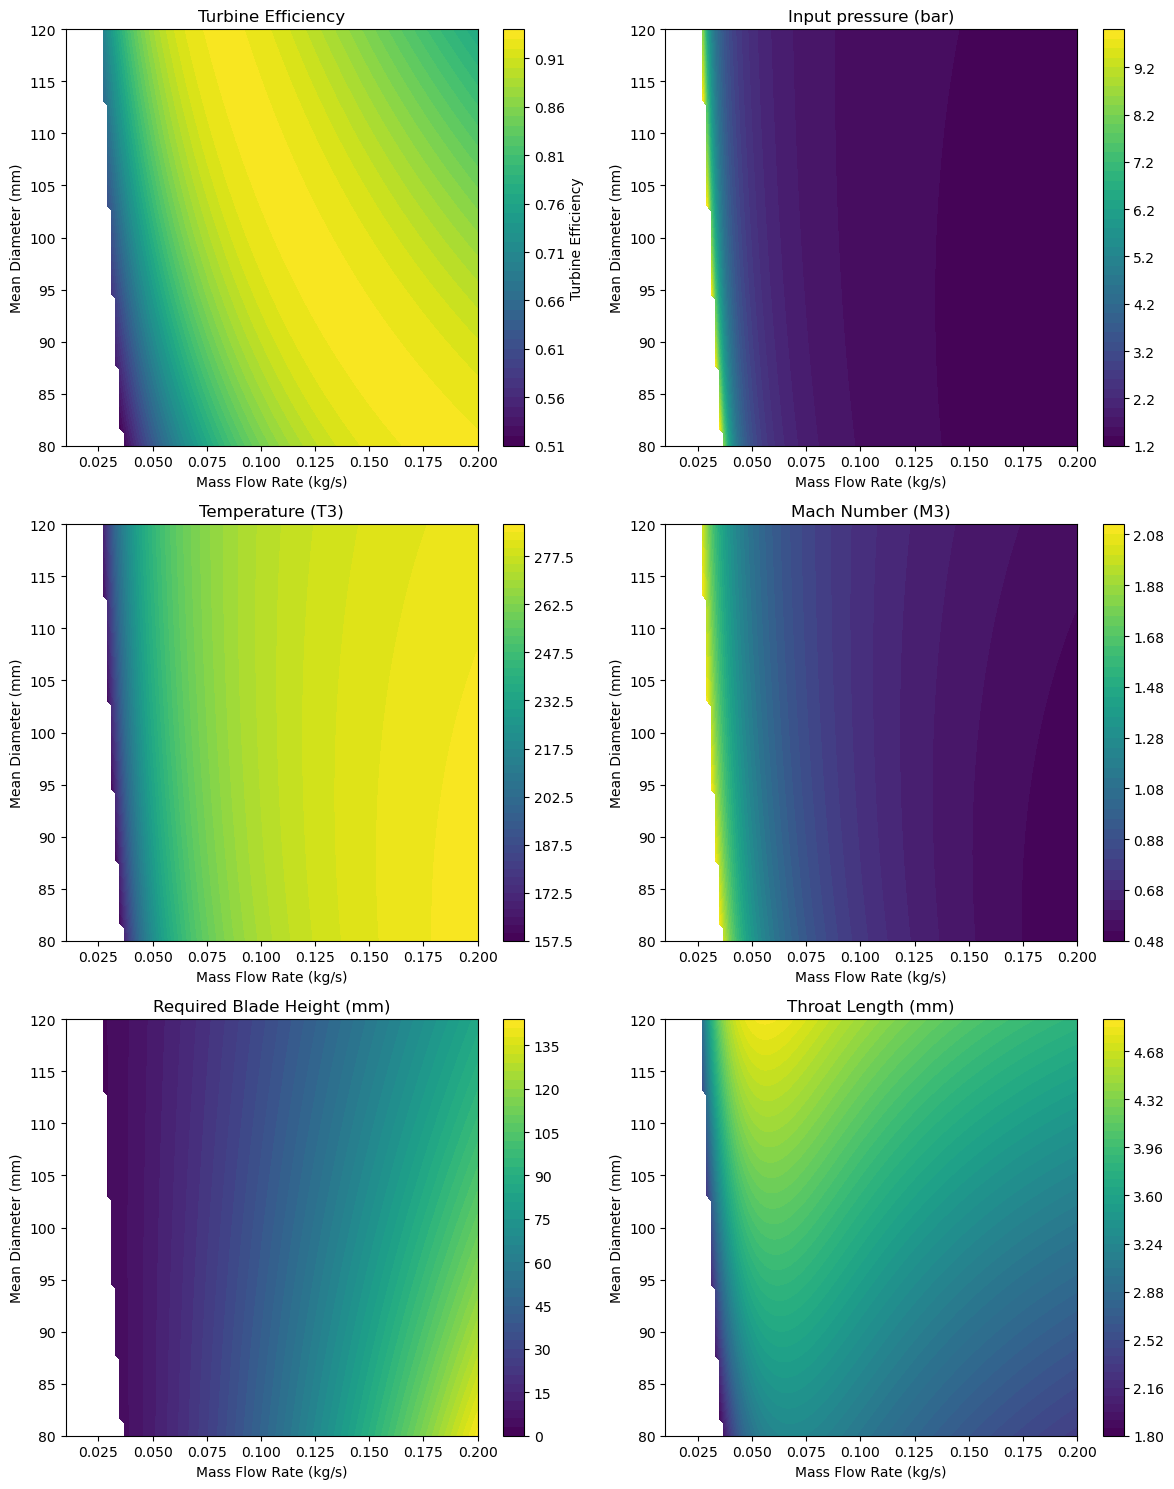

In [4]:
import numpy as np
import matplotlib.pyplot as plt

diameters = np.linspace(80, 120, 100)
massflows = np.linspace(0.01, 0.2, 100)

# diameters = np.linspace(50, 70, 100)
# massflows = np.linspace(0.015, 0.025, 100)

efficiencies = np.zeros((len(diameters), len(massflows)))
p01s = np.zeros((len(diameters), len(massflows)))
t3s = np.zeros((len(diameters), len(massflows)))
M3s = np.zeros((len(diameters), len(massflows)))
heights = np.zeros((len(diameters), len(massflows)))
throat_length = np.zeros((len(diameters), len(massflows)))
for i, diameter in enumerate(diameters):
    # print(f"Simulating diameter {diameter} mm ({i+1}/{len(diameters)})")
    for j, mdot in enumerate(massflows):
        try:
            stage = Turbine(
                P=2600,       # W
                RPM=20000,     
                d_mean_mm=diameter, # mm
                mdot=mdot,     # kg/s
                beta_deg=15,   # degrees
                doa=0.1,       # degree of admission
                p_e=1.1e5,
                )
            stage.from_inert_gas(
                R=296.8,  # J/kg/K for N2
                gam=1.4,
                T01=300,  # K
                nozzles=2,
            )
            efficiencies[i, j] = stage.eff
            p01s[i, j] = stage.p01
            t3s[i, j] = stage.T3
            M3s[i, j] = stage.M3
            heights[i, j] = stage.Height
            throat_length[i, j] = stage.nozzle_throat_length
            
            if stage.p01 > 10e5 or stage.T3 < 0:
                efficiencies[i, j] = np.nan
                p01s[i, j] = np.nan
                t3s[i, j] = np.nan
                M3s[i, j] = np.nan
                heights[i, j] = np.nan
                throat_length[i, j] = np.nan
                
        except:
            efficiencies[i, j] = np.nan
            p01s[i, j] = np.nan
            t3s[i, j] = np.nan
            M3s[i, j] = np.nan
            heights[i, j] = np.nan
            throat_length[i, j] = np.nan
            
# Plot efficiency heatmap
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Top-left: Efficiency
eff_masked = np.ma.array(efficiencies, mask=np.isnan(efficiencies))
cs0 = axs[0, 0].contourf(massflows, diameters, eff_masked, levels=50, cmap='viridis')
fig.colorbar(cs0, ax=axs[0, 0], label='Turbine Efficiency')
axs[0, 0].set_xlabel('Mass Flow Rate (kg/s)')
axs[0, 0].set_ylabel('Mean Diameter (mm)')
axs[0, 0].set_title('Turbine Efficiency')

# Top-right: Total input pressure
out_masked = np.ma.array(p01s, mask=np.isnan(p01s))
cs1 = axs[0, 1].contourf(massflows, diameters, out_masked / 1e5, levels=50, cmap='viridis')
fig.colorbar(cs1, ax=axs[0, 1])
axs[0, 1].set_xlabel('Mass Flow Rate (kg/s)')
axs[0, 1].set_ylabel('Mean Diameter (mm)')
axs[0, 1].set_title('Input pressure (bar)')

# Nozzle exit temperature
    
out2_masked = np.ma.array(t3s, mask=np.isnan(t3s))
cs2 = axs[1, 0].contourf(massflows, diameters, out2_masked, levels=50, cmap='viridis')
fig.colorbar(cs2, ax=axs[1, 0])
axs[1, 0].set_xlabel('Mass Flow Rate (kg/s)')
axs[1, 0].set_ylabel('Mean Diameter (mm)')
axs[1, 0].set_title('Temperature (T3)')

# Nozzle exit Mach number

out3_masked = np.ma.array(M3s, mask=np.isnan(M3s))
cs3 = axs[1, 1].contourf(massflows, diameters, out3_masked, levels=50, cmap='viridis')
fig.colorbar(cs3, ax=axs[1, 1])
axs[1, 1].set_xlabel('Mass Flow Rate (kg/s)')
axs[1, 1].set_ylabel('Mean Diameter (mm)')
axs[1, 1].set_title('Mach Number (M3)')

# Required blade height

out4_masked = np.ma.array(heights, mask=np.isnan(heights))
cs4 = axs[2, 0].contourf(massflows, diameters, out4_masked * 1000, levels=50, cmap='viridis')
fig.colorbar(cs4, ax=axs[2, 0])
axs[2, 0].set_xlabel('Mass Flow Rate (kg/s)')
axs[2, 0].set_ylabel('Mean Diameter (mm)')
axs[2, 0].set_title('Required Blade Height (mm)')

# Throat length

out5_masked = np.ma.array(throat_length, mask=np.isnan(throat_length))
cs5 = axs[2, 1].contourf(massflows, diameters, out5_masked * 1000, levels=50, cmap='viridis')
fig.colorbar(cs5, ax=axs[2, 1])
axs[2, 1].set_xlabel('Mass Flow Rate (kg/s)')
axs[2, 1].set_ylabel('Mean Diameter (mm)')
axs[2, 1].set_title('Throat Length (mm)')

# # N2 required inlet pressure

# out5_masked = np.ma.array(n2_p01s, mask=np.isnan(n2_p01s))
# cs5 = axs[2, 1].contourf(massflows, diameters, out5_masked / 1e5, levels=50, cmap='viridis')
# fig.colorbar(cs5, ax=axs[2, 1])
# axs[2, 1].set_xlabel('Mass Flow Rate (kg/s)')
# axs[2, 1].set_ylabel('Mean Diameter (mm)')
# axs[2, 1].set_title('N2 Required Inlet Pressure (bar)')

# # N2 required exit pressure
# out6_masked = np.ma.array(n2_p3s, mask=np.isnan(n2_p3s))
# cs6 = axs[3, 0].contourf(massflows, diameters, out6_masked / 1e5, levels=50, cmap='viridis')
# fig.colorbar(cs6, ax=axs[3, 0])
# axs[3, 0].set_xlabel('Mass Flow Rate (kg/s)')
# axs[3, 0].set_ylabel('Mean Diameter (mm)')
# axs[3, 0].set_title('N2 Exit Pressure (bar)')

# # N2 required exit temperature
# out7_masked = np.ma.array(n2_t3s, mask=np.isnan(n2_t3s))
# cs7 = axs[3, 1].contourf(massflows, diameters, out7_masked, levels=50, cmap='viridis')
# fig.colorbar(cs7, ax=axs[3, 1])
# axs[3, 1].set_xlabel('Mass Flow Rate (kg/s)')
# axs[3, 1].set_ylabel('Mean Diameter (mm)')
# axs[3, 1].set_title('N2 Exit Temperature (K)')

# # N2 required mass flow rate
# out8_masked = np.ma.array(n2_mdots, mask=np.isnan(n2_mdots))
# cs8 = axs[4, 0].contourf(massflows, diameters, out8_masked * 1000, levels=50, cmap='viridis')
# fig.colorbar(cs8, ax=axs[4, 0])
# axs[4, 0].set_xlabel('Mass Flow Rate (kg/s)')
# axs[4, 0].set_ylabel('Mean Diameter (mm)')
# axs[4, 0].set_title('N2 Mass Flow Rate (g/s)')

# # N2 required exit velocity
# out9_masked = np.ma.array(n2_c3s, mask=np.isnan(n2_c3s))
# cs9 = axs[4, 1].contourf(massflows, diameters, out9_masked, levels=50, cmap='viridis')
# fig.colorbar(cs9, ax=axs[4, 1])
# axs[4, 1].set_xlabel('Mass Flow Rate (kg/s)')
# axs[4, 1].set_ylabel('Mean Diameter (mm)')
# axs[4, 1].set_title('N2 Exit Velocity (m/s)')   

plt.tight_layout()
plt.show()


In [9]:
stage = Turbine(
    P=2600,       # W
    RPM=20000,     
    d_mean_mm=100, # mm
    mdot=0.034,     # kg/s
    beta_deg=15,   # degrees
    doa=0.1,       # degree of admission
    p_e=1.1e5,
    )
stage.from_inert_gas(
    R=296.8,  # J/kg/K for N2
    gam=1.4,
    T01=300,  # K
    nozzles=2
)
stage.pretty_print()
stage.partload_rpm(17000)

Turbine Results:---------------------------
Inputs:
  Power (P)                      2.6        kW
  RPM                            2e+04      RPM
  Mean Diameter (d_mean)         100        mm
  GG mdot                        34         g/s
  Nozzle Angle                   15         degree
  Degree of Admission            10        %
Outputs:
  GG Temperature (T01)           300        K
  Nozzle Exit Gamma              1.4       
  Nozzle Exit Gas Constant       296.8      J/kg/K
  GG Chamber Pressure            5.849      bar
  Rotor surface speed (u)        104.7      m/s
  Specific heat delta (dh_use)   7.647e+04  J/kg
  Absolute Circ. Velocity (c3u)  469.8      m/s
  Absolute Meri. Velocity (c3m)  125.9      m/s
  Absolute Velocity (c3)         486.4      m/s
  Swirl Velocity (c4u)           -260.4     m/s
  Absolute Velocity at exit (c4) 289.2      m/s
  Exit Temperature (T3)          186.1      K
  Exit sonic velocity (a3)       278.1      m/s
  Exit Pressure (p3)             

Engine Sizing Results:-----------------------
  Chamber Pressure               20         bar
  Nozzle Exit Pressure           1          bar
  Thrust                         2100       N
  Nozzle Expansion Ratio (eps)   3.267     
  Thrust Coefficient (cf)        1.389     
  Throat Diameter                31.02      mm
  Characteristic Velocity (cstar) 1438       m/s
  Mass Flow Rate (mdot)          1.051      kg/s
  Fuel Mass Flow Rate            0.3003     kg/s
  Oxidizer Mass Flow Rate        0.7507     kg/s
  Sea Level Isp (isp_sea)        203.8      s
Barske Impeller:---------------------------
Main results:
  RPM                            20000.00
  Required Power                 2567.47 W
  Diameter at Outlet             0.05852 m
  Mass flow rate (mdot)          0.3        kg/s
  Outlet Head (H)                203.9      m
  Rotational speed (n)           2e+04      rpm
  Flow rate (Q)                  0.0003     m^3/s
  Specific speed (n_q)           6.421     
Detailed Res

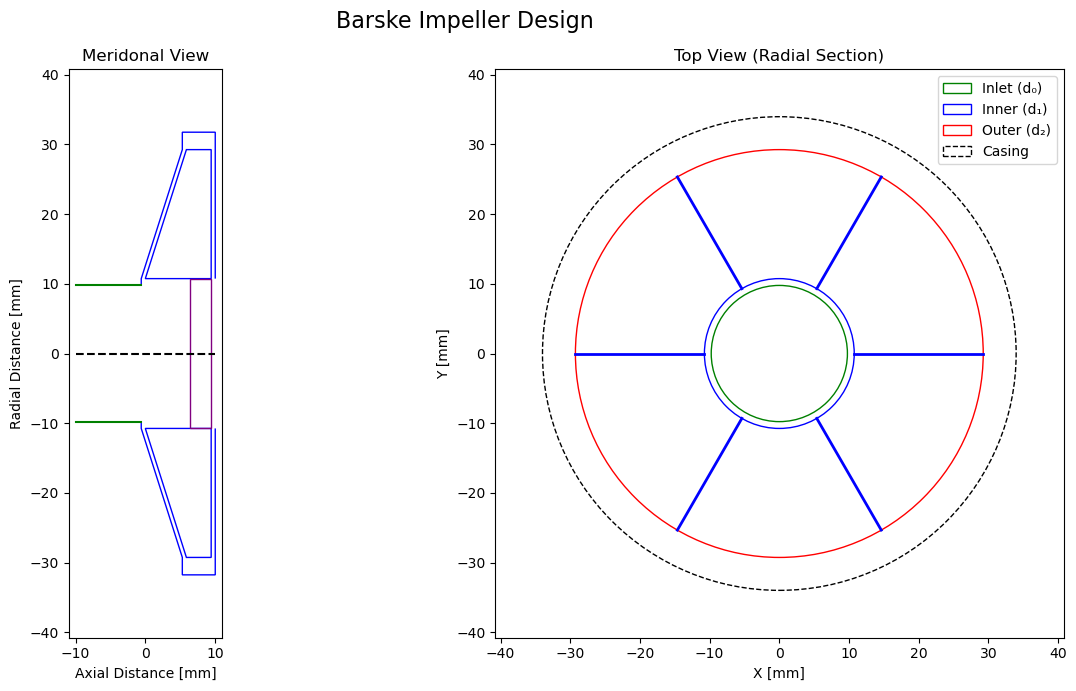

In [13]:
def main():
    thrust = 2100
    engine = Engine(ox='N2O', fuel='Isopropanol')
    eps, cf, at, cstar, mdot, isp_sea = engine.size(OF=2.5, pc=20, pe=1, thrust=thrust)
    throat_diameter = np.sqrt(at / (np.pi/4))
    fuel_mdot = mdot / (1 + 2.5)
    oxidizer_mdot = mdot - fuel_mdot
    print(f"Engine Sizing Results:-----------------------")
    print(f"  {'Chamber Pressure':<30} {20:<10.4g} bar")
    print(f"  {'Nozzle Exit Pressure':<30} {1:<10.4g} bar")
    print(f"  {'Thrust':<30} {thrust:<10.4g} N")
    print(f"  {'Nozzle Expansion Ratio (eps)':<30} {eps:<10.4g}")
    print(f"  {'Thrust Coefficient (cf)':<30} {cf:<10.4g}")
    print(f"  {'Throat Diameter':<30} {throat_diameter*1000:<10.4g} mm")
    print(f"  {'Characteristic Velocity (cstar)':<30} {cstar:<10.4g} m/s")
    print(f"  {'Mass Flow Rate (mdot)':<30} {mdot:<10.4g} kg/s")
    print(f"  {'Fuel Mass Flow Rate':<30} {fuel_mdot:<10.4g} kg/s")
    print(f"  {'Oxidizer Mass Flow Rate':<30} {oxidizer_mdot:<10.4g} kg/s")
    print(f"  {'Sea Level Isp (isp_sea)':<30} {isp_sea:<10.4g} s")


    top_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=False)
    bot_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=True)
    seal_59U14 = MechanicalSeal(OD_mm=19.5, ID_mm=15, BD_mm=14, F_sp=100)

    impeller = BarskeImpeller(
        mdot_desired=0.3,  # kg/s
        p_desired=20 * 1e5,    # Pa
        rho=1000,           # kg/m3
        visc=1.002e-6,          # Pa.s
        RPM=20000,
        top_bearing=top_bearing,
        bot_bearing=bot_bearing,
        mechanical_seal=seal_59U14)
    impeller.pretty_print()
    impeller.visualize()
main()


In [1]:
from turbine import Turbine


stage = Turbine(
    P=2600,       # W
    RPM=20000,     
    d_mean_mm=100, # mm
    mdot=0.1,     # kg/s
    beta_deg=15,   # degrees
    doa=0.1,       # degree of admission
    p_e=1.1e5,
    )
stage.from_inert_gas(
    R=296.8,  # J/kg/K for N2
    gam=1.4,
    T01=300,  # K
    nozzles=2
)
stage.pretty_print()
stage.partload_rpm(17000)


Turbine Results:---------------------------
Inputs:
  Power (P)                      2.6        kW
  RPM                            2e+04      RPM
  Mean Diameter (d_mean)         100        mm
  GG mdot                        100        g/s
  Nozzle Angle                   15         degree
  Degree of Admission            10        %
Outputs:
  GG Temperature (T01)           300        K
  Nozzle Exit Gamma              1.4       
  Nozzle Exit Gas Constant       296.8      J/kg/K
  GG Chamber Pressure            1.531      bar
  Rotor surface speed (u)        104.7      m/s
  Specific heat delta (dh_use)   2.6e+04    J/kg
  Absolute Circ. Velocity (c3u)  228.9      m/s
  Absolute Meri. Velocity (c3m)  61.32      m/s
  Absolute Velocity (c3)         236.9      m/s
  Swirl Velocity (c4u)           -19.42     m/s
  Absolute Velocity at exit (c4) 64.32      m/s
  Exit Temperature (T3)          273        K
  Exit sonic velocity (a3)       336.8      m/s
  Exit Pressure (p3)             